Use ipython kernel install --name "name of the viertual env" --user 
To add the kernel to jupyter and display hints and so on
Then Select the kernel

In [60]:
import datetime
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

from datetime import datetime
import requests

import mlflow

import os

## Setup MLFlow (external server option)

In [2]:
MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI") or "http://176.34.140.12/:8080"

'http://3.252.84.89:8080'

In [3]:
PROJECT_ID = os.getenv("PROJECT_ID") or "chicago_taxi"
MLFLOW_MODEL_NAME = os.getenv("MODEL_NAME") or "chicago_taxi"

In [4]:
MLFLOW_EXPERIMENT_NAME = "mlflow/" + PROJECT_ID

In [5]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.sklearn.autolog()

In [6]:
mlflow.get_tracking_uri()

'http://3.252.84.89:8080'

In [7]:
# Don't use this since it will start a run for this that will stay unfinished
# mlflow.get_artifact_uri()

In [8]:
mlflow.get_registry_uri()

'http://3.252.84.89:8080'

https://data.cityofchicago.org/Transportation/Taxi-Trips-by-Month/x3ws-m7si
https://data.cityofchicago.org/api/views/wrvz-psew/rows.csv?query=select%20*%20where%20%60trip_start_timestamp%60%20%3E%3D%20%272022-01-01%27%20AND%20%60trip_start_timestamp%60%20%3C%20%272022-02-01%27&read_from_nbe=true&version=2.1&accessType=DOWNLOAD

## Set constants

In [9]:
DATA_PATH = "data/"
TRAIN_MONTH = 2
VAL_MONTH = 3
TEST_MONTH = 4
TRAIN_SET = f"Taxi_Trips_2022_{TRAIN_MONTH:02d}.csv"
VAL_SET = f"Taxi_Trips_2022_{VAL_MONTH:02d}.csv"
TEST_SET = f"Taxi_Trips_2022_{TEST_MONTH:02d}.csv"
TRAIN_PATHFILE = DATA_PATH + TRAIN_SET
VAL_PATHFILE = DATA_PATH + VAL_SET
TEST_PATHFILE = DATA_PATH + TEST_SET
NUM_OF_DAYS = 2

## Download training, validation datasets

In [10]:
def download_file(url:str, output_filename:str):
    if output_filename == None:
        output_filename = url.split('/')[-1]
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return output_filename

In [11]:
def download_dataset(start_date, end_date, output_filename:str):
    
    start_date = start_date.strftime('%Y-%m-%d')
    end_date = end_date.strftime('%Y-%m-%d')
    
    uri = f"https://data.cityofchicago.org/api/views/wrvz-psew/rows.csv?" + \
    "query=select%20*%20where%20%60trip_start_timestamp%60%20%3E%3D%20%27" + \
    f"{start_date}%27%20AND%20%60trip_start_timestamp%60%20%3C%20%27" + \
    f"{end_date}%27&read_from_nbe=true&version=2.1&accessType=DOWNLOAD"
    output_filename = download_file(uri, output_filename)

    return output_filename

In [12]:
 if not os.path.exists(DATA_PATH):
        os.makedirs(DATA_PATH)

In [13]:
download_dataset(datetime(2022,TRAIN_MONTH,1),datetime(2022,TRAIN_MONTH,NUM_OF_DAYS), TRAIN_PATHFILE)
download_dataset(datetime(2022,VAL_MONTH,1),datetime(2022,VAL_MONTH,NUM_OF_DAYS), VAL_PATHFILE)
download_dataset(datetime(2022,TEST_MONTH,1),datetime(2022,TEST_MONTH,NUM_OF_DAYS), VAL_PATHFILE)

'data/Taxi_Trips_2022_03.csv'

## Read datasets and convert to parket

In [14]:
def read_dataframe_csv(filename: str, parse_dates: List[str]=[], dtype={'Pickup Community Area':str,'Dropoff Community Area':str}):
    df = pd.read_csv(filename, parse_dates=parse_dates, dtype=dtype)
    df.columns = df.columns.str.lower().str.replace(' ','_')
    output_file_name = filename.replace('csv','parquet')
    df.to_parquet(output_file_name,engine='pyarrow',index=None)
    return output_file_name

In [15]:
DATE_FIELDS = ['Trip Start Timestamp','Trip End Timestamp']
DTYPE = {'Pickup Community Area':str,'Dropoff Community Area':str}

In [18]:
train_file_name = read_dataframe_csv(filename=TRAIN_PATHFILE, parse_dates=DATE_FIELDS, dtype=DTYPE)
df_raw_train = pd.read_parquet(train_file_name)
df_raw_val = pd.read_parquet(read_dataframe_csv(filename=VAL_PATHFILE, parse_dates=DATE_FIELDS))
df_raw_test = pd.read_parquet(read_dataframe_csv(filename=TEST_PATHFILE, parse_dates=DATE_FIELDS))

In [19]:
df_raw_train.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid__location
0,0559c3390e688c3a87b359831081fe53f9518658,99b1203df31b26f1c372e57926d731514ae839dbb485f3...,2022-02-01,2022-02-01 00:00:00,540.0,1.4,NaN,NaN,28,32,...,0.0,9.75,Credit Card,Top Cab Affiliation,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
1,0fa79ae1034f0c7feb446f8e7df4d3a99210d396,0a2412f478181908974ce4f03ac52607833c0a92f3c4ff...,2022-02-01,2022-02-01 00:00:00,33.0,0.0,NaN,NaN,8,8,...,0.0,24.60,Credit Card,Globe Taxi,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2,13efae785f8e9bfac7a1d53a38ff11c5b89cd97d,f1c4fb891f4812fb2865e801d2185b401283b34401b71f...,2022-02-01,2022-02-01 00:15:00,660.0,0.5,NaN,NaN,8,11,...,0.0,24.75,Unknown,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.978830,-87.771167,POINT (-87.771166703 41.9788295262)
3,21b691983aee6b1d93cae2afffe147bce834a546,19ccfdbec42380e8beda815e0a69bd92aaec6bc3982643...,2022-02-01,2022-02-01 00:15:00,1680.0,7.5,NaN,NaN,76,3,...,5.0,45.75,Cash,"Taxicab Insurance Agency, LLC",41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
4,4256163d5455ca8fb6408bc1a9d614e5c135cb42,8942c504d38b52d769ac1800e8c7dde070687626dcae14...,2022-02-01,2022-02-01 00:00:00,660.0,0.1,NaN,NaN,32,8,...,0.0,9.75,Credit Card,Taxi Affiliation Services,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)


## Analyse a dataset to select features and further process to be done

In [20]:
def analyse_dataframe(df: pd.DataFrame, target:str =None, verbose=False):
    
    print(f'Analysing dataset...')
    print(f'shape: {df.shape}')
    print(f'types:\n{df.dtypes}')
    df.head().T
    
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
    
    for column in df.columns:
        print('\n' + column)
        if column in categorical_columns:
            print('Suggested type: categorical')
        else:
            print('Suggested type: numerical')
        nuniques = df[column].nunique()
        if nuniques < 50:
            print(column, df[column].unique())
        else:
            print(f'Number of uniques values is {nuniques}')
        
        print(f'Number of nulls: {df[column].isnull().sum()}')
    
    sns.displot(df[target], kind='kde')
    
    print(f'\ndescription of {target}:')
    print(df[target].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.75, 0.95, 0.98, 0.99]))
    print(f'% of trips within 1-60 min: {((df[target] >= 60) & (df[target]<=60*60)).mean()}')
    
    return numerical_columns, categorical_columns

Analysing dataset...
shape: (12698, 23)
types:
trip_id                               object
taxi_id                               object
trip_start_timestamp          datetime64[ns]
trip_end_timestamp            datetime64[ns]
trip_seconds                         float64
trip_miles                           float64
pickup_census_tract                  float64
dropoff_census_tract                 float64
pickup_community_area                 object
dropoff_community_area                object
fare                                 float64
tips                                 float64
tolls                                float64
extras                               float64
trip_total                           float64
payment_type                          object
company                               object
pickup_centroid_latitude             float64
pickup_centroid_longitude            float64
pickup_centroid_location              object
dropoff_centroid_latitude            float64
dropoff_

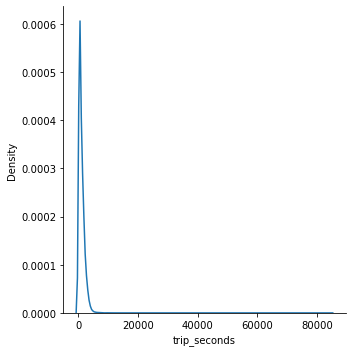

In [21]:
numerical_columns, categorical_columns = analyse_dataframe(df_raw_train, target='trip_seconds')

## Preprocess data

In [22]:
def preprocess_data (df:pd.DataFrame, categorical_features:List[str], numerical_features:List[str], verbose:bool=False):

    """
    drop records where, trip_start_timestamp, trip_seconds are NaNs
    drops records where trip_seconds < 60 or > 3600
    create duration in minutes as target
    categorical fillnans with -1
    categorical value formatting
    categorical to str
    keep only categorical and numerical fetures
    Return df and target
    """
    
    df = df[df.trip_seconds.notnull()]
    df = df[df.trip_start_timestamp.notnull()]
    df = df[(df.trip_seconds > 60) & (df.trip_seconds < 3600)]
    df['duration'] = df['trip_seconds'] / 60 
    
    
    for column in categorical_features:
        if (verbose): print(f'\nFilling {round(df[column].isna().mean()*100,2)}% of nans with -1 in column: {column}')
        df[column].fillna(-1, inplace=True)
        df[column] = df[column].astype('str')
        # This will not touch the None values, only the not None types are processed
        df[column] = df[column].str.lower().str.replace(' ', '_')
        
    target = ['duration']

    df.drop(df.columns.difference(categorical_features+numerical_features+target), axis=1, inplace=True)
    
    if verbose:
        print(f'\nfinal shape: {df.shape}')
        print(f'\nfinal types:\n{df.dtypes}')
        print(f'\ncategorical_features: {categorical_features}')
        print(f'\nnumerical_features: {numerical_features}')
        print(f'\ntarget: {target}')
        
    return df[categorical_features+numerical_features], df[target]

In [103]:
df_train, y_train = preprocess_data(
    df_raw_train,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[],
    verbose=True
)


Filling 5.95% of nans with -1 in column: pickup_community_area

Filling 8.27% of nans with -1 in column: dropoff_community_area

final shape: (11529, 3)

final types:
pickup_community_area      object
dropoff_community_area     object
duration                  float64
dtype: object

categorical_features: ['pickup_community_area', 'dropoff_community_area']

numerical_features: []

target: ['duration']


In [104]:
df_val, y_val = preprocess_data(
    df_raw_val,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[],
    verbose=True
)


Filling 6.91% of nans with -1 in column: pickup_community_area

Filling 9.61% of nans with -1 in column: dropoff_community_area

final shape: (17870, 3)

final types:
pickup_community_area      object
dropoff_community_area     object
duration                  float64
dtype: object

categorical_features: ['pickup_community_area', 'dropoff_community_area']

numerical_features: []

target: ['duration']


In [105]:
df_test, y_test = preprocess_data(
    df_raw_test,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[],
    verbose=True
)


Filling 6.91% of nans with -1 in column: pickup_community_area

Filling 9.61% of nans with -1 in column: dropoff_community_area

final shape: (17870, 3)

final types:
pickup_community_area      object
dropoff_community_area     object
duration                  float64
dtype: object

categorical_features: ['pickup_community_area', 'dropoff_community_area']

numerical_features: []

target: ['duration']


## Prepare dictionaries based on categorial and numerial features chosen

In [106]:
def prepare_dictionaries(df:pd.DataFrame, categorical_features:List[str], numerical_features:List[str]):
    dicts = df[categorical_features + numerical_features].to_dict(orient='records')
    return dicts

In [110]:
train_dict = prepare_dictionaries(
    df_train,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[]
)
val_dict = prepare_dictionaries(
    df_val,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[]
)
test_dict = prepare_dictionaries(
    df_test,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[]
)

In [108]:
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

## Create DictVectorizer

In [111]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

## Experiment 1: Linear regression

In [29]:
with mlflow.start_run():
    
    mlflow.set_tag("developer","marcos")
    mlflow.log_param("train-data-path",TRAIN_PATHFILE)
    mlflow.log_param("val-data-path",VAL_PATHFILE)
    # Todo Log checksum of data files
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_pred, y_val, squared=False)
    print(f'rmse = {rmse:.3f}')
    mlflow.log_metric("val_rmse", rmse)

rmse = 10.020


In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print(f"Sample number 50: {X_train[50]} => {y_pred[50]}")

2022/09/19 16:05:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aabc2609b8b24e938ee83634ac1b5ceb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Sample number 50:   (0, 1)	1.0
  (0, 83)	1.0 => [29.7125601]


In [31]:
X_train[50]

<1x156 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

C:\Users\MARCOS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\MARCOS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


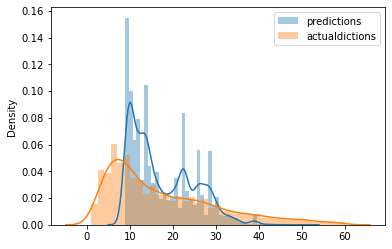

In [32]:
sns.distplot(y_pred, label='predictions')
sns.distplot(y_train, label='actualdictions')
plt.legend()
plt.show()

## Set of experiments with different regression models

In [73]:
now = datetime.now().timestamp()*1000

In [74]:
ensemble_models = [GradientBoostingRegressor, ExtraTreesRegressor]
basic_models = [LinearRegression, Lasso, Ridge]
svm_models = [LinearSVR]
model_classes = ensemble_models + basic_models + svm_models
model_params = [None, None, None, {'alpha': 0.1}, None, None]

for i, model_class in enumerate(model_classes):

    with mlflow.start_run():
        
        print(model_class)
        mlflow.set_tag("developer", "marcos")
        mlflow.log_param("train-data-path",TRAIN_PATHFILE)
        mlflow.log_param("val-data-path",VAL_PATHFILE)

        if model_params[i]:
            model = model_class(**model_params[i])
        else:
            model = model_class()
            
        if model_class in ensemble_models+svm_models:
            model.fit(X_train, y_train.ravel())
        else:
            model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("val_rmse", rmse)
        print(f'rmse = {rmse}')

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
rmse = 10.231558880512893
<class 'sklearn.ensemble._forest.ExtraTreesRegressor'>
rmse = 7.972721816627162
<class 'sklearn.linear_model._base.LinearRegression'>
rmse = 10.673470290475867
<class 'sklearn.linear_model._coordinate_descent.Lasso'>
rmse = 11.208331487681187
<class 'sklearn.linear_model._ridge.Ridge'>
rmse = 10.67485786657217
<class 'sklearn.svm._classes.LinearSVR'>
rmse = 10.891392701614118


## Experiment Random Forest Regressor with Pipeline

In [41]:
with mlflow.start_run():
    mlflow.set_tag("developer", "marcos")
    mlflow.log_param("train-data-path",TRAIN_PATHFILE)
    mlflow.log_param("val-data-path",VAL_PATHFILE)
    params = dict(max_depth=20, n_estimators=100, min_samples_leaf=10, random_state=0)
    pipeline = make_pipeline(
        DictVectorizer(),
        RandomForestRegressor(**params, n_jobs=1))
    pipeline.fit(train_dict, y_train.ravel())
    y_pred = pipeline.predict(val_dict)
    rmse = mean_squared_error(y_pred, y_val, squared=False)
    mlflow.log_metric("val_rmse", rmse)
    print(f'rmse = {rmse:.3f}')

2022/09/19 16:11:49 WARNING mlflow.sklearn: Failed to infer model signature: Expected one of (pandas.DataFrame, numpy array, dictionary of (name -> numpy.ndarray), pyspark.sql.DataFrame) but got '<class 'list'>'


rmse = 8.777


In [42]:
y_pred = pipeline.predict(train_dict)

In [43]:
print(f'rmse = {mean_squared_error(y_pred, y_train, squared=False)}')

rmse = 9.562125968966342


## Get the 3 best models found in this execution and register them

In [75]:
client = mlflow.tracking.MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)    

In [76]:
experiment_id = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME).experiment_id

In [85]:
client.list_experiments()
runs = client.search_runs(
    experiment_ids = [experiment_id],
    filter_string = f"attribute.start_time>{int(now)} and metrics.val_rmse < 20",
    run_view_type = mlflow.entities.ViewType.ACTIVE_ONLY,
    max_results = 3,
    order_by = ["metrics.val_rmse ASC"])

In [119]:
best_model = 0
best_rmse = float("inf")
for run in runs:
    run_id =run.info.run_id
    print(f"Run id: {run_id}, val_rmse: {run.data.metrics['val_rmse']:.3f}")
    model_uri = f"runs:/{run_id}/model"
    
    model = mlflow.pyfunc.load_model(model_uri)
    y_pred = model.predict(X_test)
    test_rmse = mean_squared_error(y_test,y_pred, squared=False)
    print(f"Run id: {run_id}, test_rmse: {test_rmse:.3f}")
    
    # Update the metrics in these experiments
    client.log_metric(run.info.run_id, "test_rmse", test_rmse)
    
    model_version = mlflow.register_model(
        model_uri=model_uri,
        name=MLFLOW_MODEL_NAME,
        # tags={'test_rmse': test_rmse}
    )
    
    if (test_rmse < best_rmse):
        best_model = model_version
        best_rmse = test_rmse

Run id: 2697bd118a42441abd3ef0e6f4e94b60, val_rmse: 7.973
Run id: 2697bd118a42441abd3ef0e6f4e94b60, test_rmse: 9.096


Registered model 'chicago_taxi' already exists. Creating a new version of this model...
2022/09/19 17:36:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: chicago_taxi, version 50
Created version '50' of model 'chicago_taxi'.


Run id: bed8703cc02d4d61b16733c5542b8fee, val_rmse: 10.232
Run id: bed8703cc02d4d61b16733c5542b8fee, test_rmse: 9.449


Registered model 'chicago_taxi' already exists. Creating a new version of this model...
2022/09/19 17:36:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: chicago_taxi, version 51
Created version '51' of model 'chicago_taxi'.


Run id: dd715a7fb7a24c37a02292db9e8a4f73, val_rmse: 10.673
Run id: dd715a7fb7a24c37a02292db9e8a4f73, test_rmse: 10.020


Registered model 'chicago_taxi' already exists. Creating a new version of this model...
2022/09/19 17:36:37 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: chicago_taxi, version 52
Created version '52' of model 'chicago_taxi'.


In [122]:
print(f'Best model: run_id={best_model.run_id} - version={best_model.version}')

Best model: run_id=2697bd118a42441abd3ef0e6f4e94b60 - version50


## Set to Staging stage the best one, according to test dataset

In [123]:
latest_versions = client.get_latest_versions(name=MLFLOW_MODEL_NAME)
for version in latest_versions:
    print(f"Version: {version.version}, stage: {version.current_stage}")

Version: 52, stage: None
Version: 1, stage: Staging


In [124]:
client.transition_model_version_stage(
    name = MLFLOW_MODEL_NAME,
    version = best_model.version,
    stage = "Staging",
    archive_existing_versions = False)

<ModelVersion: creation_timestamp=1663601795878, current_stage='Staging', description='', last_updated_timestamp=1663601942658, name='chicago_taxi', run_id='2697bd118a42441abd3ef0e6f4e94b60', run_link='', source='s3://stg-chicago-taxi-mmjd/mlflow/2/2697bd118a42441abd3ef0e6f4e94b60/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='50'>